MDS
---
Multidimensional Scaling
* Replication of 2020 article https://link.springer.com/article/10.1007/s42113-020-00073-z (https://osf.io/efjmq)
    * Rocks dataset was created in 2017 here: https://link.springer.com/article/10.3758/s13428-017-0884-8 (https://osf.io/w64fv)
    * Further work in Sanders' 2018 doctoral thesis https://scholarworks.iu.edu/dspace/handle/2022/22415 (https://osf.io/d6b9y)
        * includes the relevant additional data such as the 360 rocks images set
* Dataset: 120 Rock Images
* We have a ready prepared file with MDS coordinates
* And we have similarity judgements from which we could compute these MDS coordinates on our own

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from glob import glob

rock_images_glob = "120 Rock Images/*.png"
rock_images = glob(rock_images_glob)
rock_images.sort() # get them in the right order

judgements_glob = "Similarity Judgments Data/rocks_similarity_120_*.txt"
judgements_files = glob(judgements_glob)

mds_file = "MDS/mds_120_supplemental_dims.txt"

## A random rock

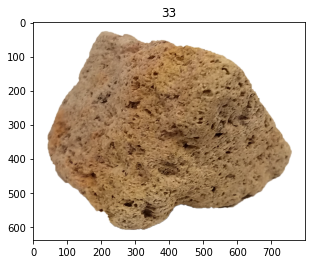

In [3]:
rock_id = 33
img = Image.open(rock_images[rock_id])
plt.imshow(img)
plt.title(rock_id);

## MDS coordinates from file

`MDS/mds_120_supplemental_dims.txt`

In [4]:
mds_obs = np.loadtxt(mds_file, skiprows=1)
mds_obs

array([[-0.72, -0.61, -0.19, ..., -1.8 , -4.5 , -5.  ],
       [ 0.3 ,  1.5 ,  1.01, ..., -2.5 , -3.  , -5.  ],
       [-0.55,  2.72, -0.24, ..., -2.55, -4.5 , -5.  ],
       ...,
       [ 0.65, -3.06,  1.93, ..., -1.05, -5.  , -2.  ],
       [-0.21, -1.53,  0.24, ..., -1.95, -5.  , -2.  ],
       [-0.78, -2.99, -0.99, ..., -0.6 , -5.  , -1.5 ]])

In [5]:
print("Number of rocks:     ", np.shape(mds_obs)[0])
print("Number of dimensions:", np.shape(mds_obs)[1])

Number of rocks:      120
Number of dimensions: 13


### Plotting rocks

In [6]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    """
    Creates scatter with image file
    """
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


def plot_rocks(dim_a, dim_b, mds_obs, rock_images):
    """
    Plots rocks for give dimensions
    """
    plt.figure(figsize = (6, 6))
    for i, rock in enumerate(rock_images):
        imscatter(mds_obs[i, dim_a-1], mds_obs[i, dim_b-1], rock, zoom = 0.033)
    plt.xlabel(f"MDS Dimension {dim_a}")
    plt.ylabel(f"MDS Dimension {dim_b}")
    return None


def plot_predictions(dim, mds_obs, cnn_pred, rock_images):
    """
    Plots rocks observed vs predicted values
    """
    
    r = np.corrcoef(cnn_pred[:, dim-1], mds_obs[:, dim-1]).min()
    
    plt.figure(figsize = (6, 6))
    for i, rock in enumerate(rock_images):
        imscatter(cnn_pred[i, dim-1], mds_obs[i, dim-1], rock, zoom = 0.02)
    plt.xlabel(f"Dimension {dim} predicted")
    plt.ylabel(f"Dimension {dim} observed")
    plt.title(f"$r$ = {r:,.2f}")
    return None

### a) Dimensions 1 vs 2

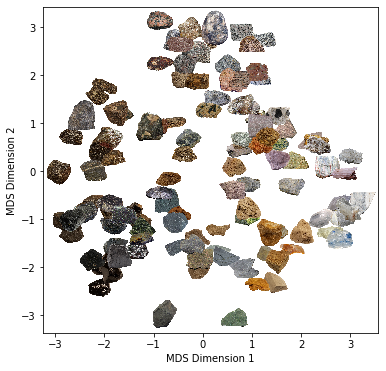

In [7]:
plot_rocks(1, 2, mds_obs, rock_images)

### b) Dimensions 3 vs 4

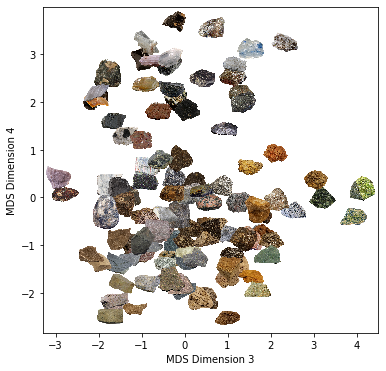

In [8]:
plot_rocks(3, 4, mds_obs, rock_images)

### c) Dimensions 5 vs 6

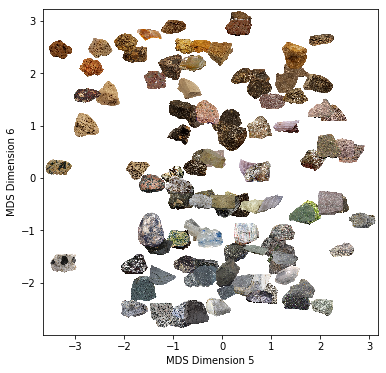

In [9]:
plot_rocks(5, 6, mds_obs, rock_images)

### d) Dimensions 7 vs 8

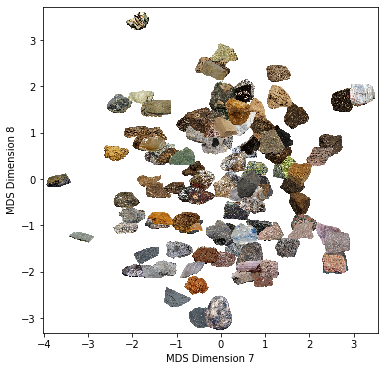

In [10]:
plot_rocks(7, 8, mds_obs, rock_images)

### e) Dimensions 8 vs 6

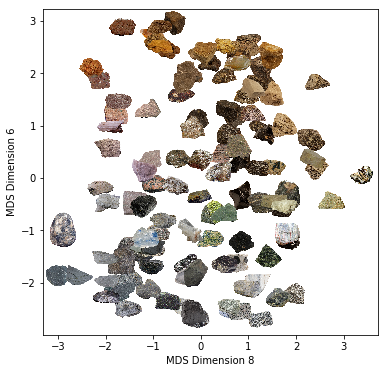

In [11]:
plot_rocks(8, 6, mds_obs, rock_images)

## MDS coordinates from similarity judgements ...
... same as above but creating the MDS coordinates by ourselves

In [12]:
len(judgements_files)

80

In [13]:
#
#
#
#
#
#
#
#
#

## CNN predicitions

* Here we use the predictions provided in the file `CNN Predictions/MDS Dimensions/cnn_predicted_mds_120.txt`
* Next step: Creating file with predicted mds coordinates on our own

In [14]:
cnn_pred_file = "CNN Predictions/MDS Dimensions/cnn_predicted_mds_120.txt"

cnn_pred = np.loadtxt(cnn_pred_file)

print("Number of rocks:     ", np.shape(cnn_pred)[0])
print("Number of dimensions:", np.shape(cnn_pred)[1])

Number of rocks:      120
Number of dimensions: 8


Lightness

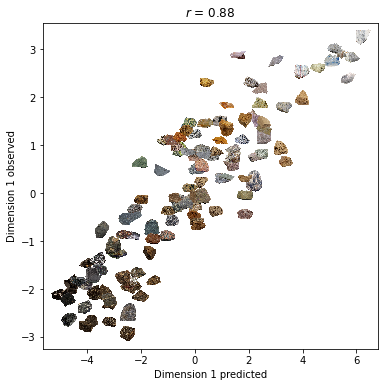

In [15]:
plot_predictions(1, mds_obs, cnn_pred, rock_images)

Grain size

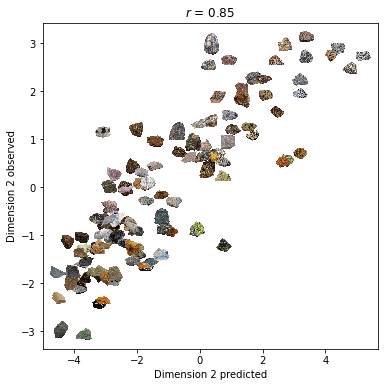

In [16]:
plot_predictions(2, mds_obs, cnn_pred, rock_images)

Roughness

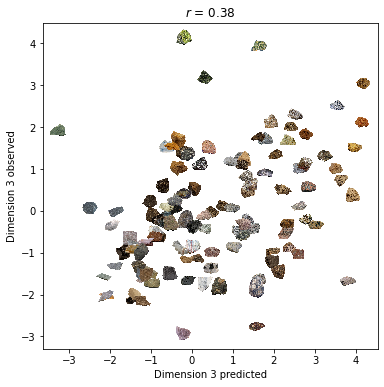

In [17]:
plot_predictions(3, mds_obs, cnn_pred, rock_images)

Shininess

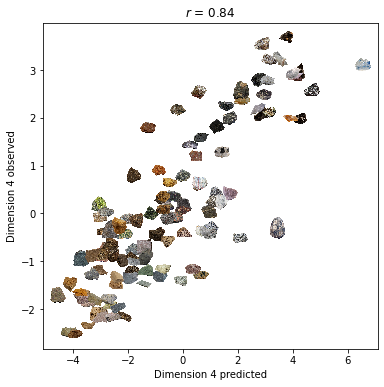

In [18]:
plot_predictions(4, mds_obs, cnn_pred, rock_images)

Organization

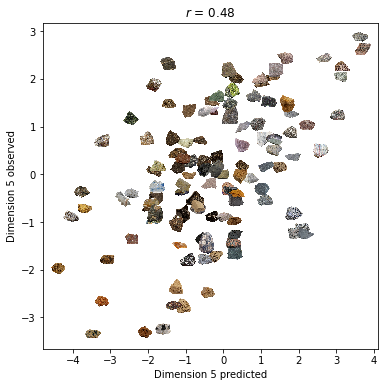

In [19]:
plot_predictions(5, mds_obs, cnn_pred, rock_images)

Chromacity

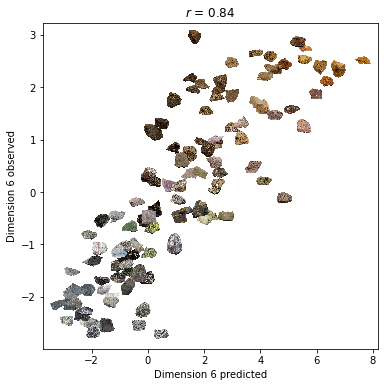

In [20]:
plot_predictions(6, mds_obs, cnn_pred, rock_images)

Shape

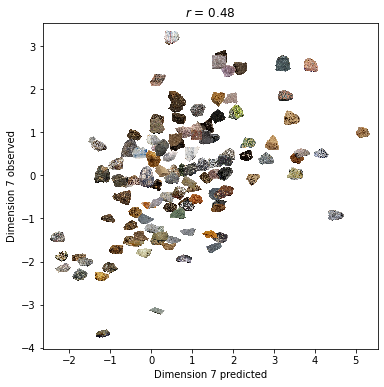

In [21]:
plot_predictions(7, mds_obs, cnn_pred, rock_images)

Hue

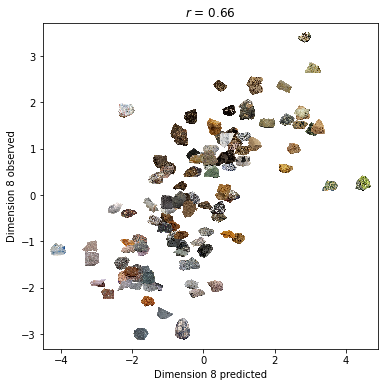

In [22]:
plot_predictions(8, mds_obs, cnn_pred, rock_images)

### Own predictions
* same as above, but using predictions by own trained model
* next step: creating same model with pytorch and do the same

In [23]:
cnn_ownpred_file = "CNN Predictions/MDS Dimensions/cnn_own_predicted_mds_120.txt"

cnn_ownpred = np.loadtxt(cnn_ownpred_file)

print("Number of rocks:     ", np.shape(cnn_ownpred)[0])
print("Number of dimensions:", np.shape(cnn_ownpred)[1])

Number of rocks:      120
Number of dimensions: 8


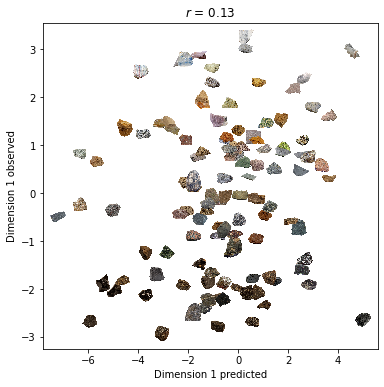

In [24]:
plot_predictions(1, mds_obs, cnn_ownpred, rock_images)

Grain size

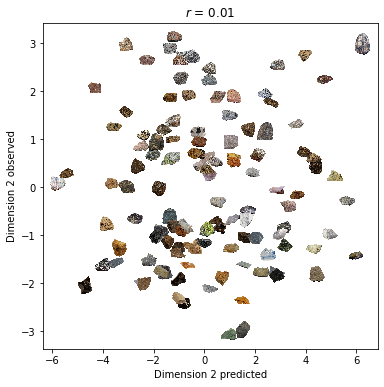

In [25]:
plot_predictions(2, mds_obs, cnn_ownpred, rock_images)

Roughness

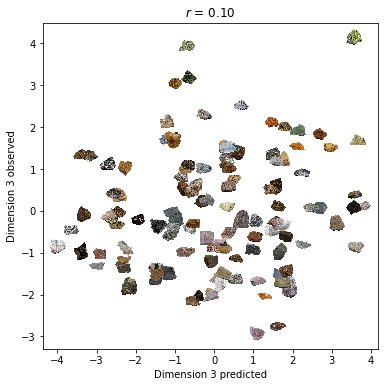

In [26]:
plot_predictions(3, mds_obs, cnn_ownpred, rock_images)

Shininess

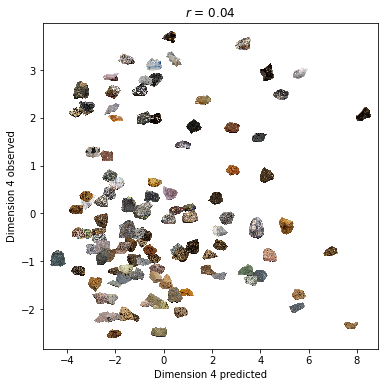

In [27]:
plot_predictions(4, mds_obs, cnn_ownpred, rock_images)

Organization

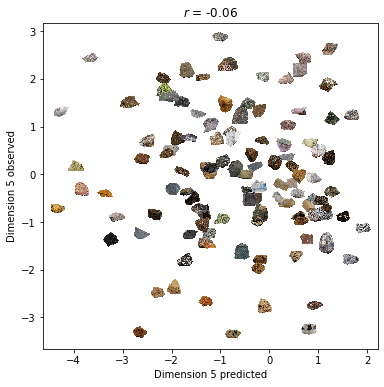

In [28]:
plot_predictions(5, mds_obs, cnn_ownpred, rock_images)

Chromacity

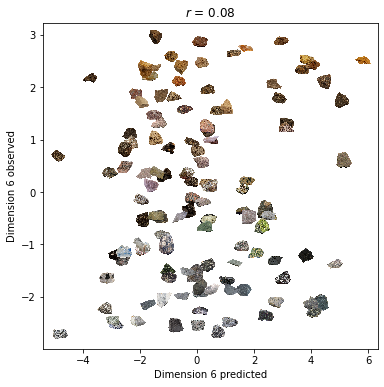

In [29]:
plot_predictions(6, mds_obs, cnn_ownpred, rock_images)

Shape

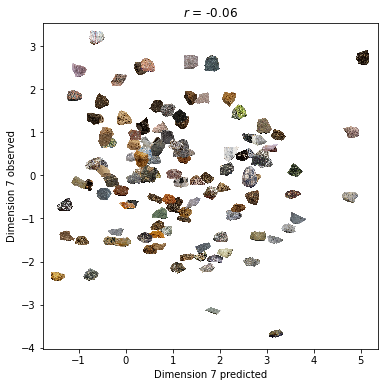

In [30]:
plot_predictions(7, mds_obs, cnn_ownpred, rock_images)

Hue

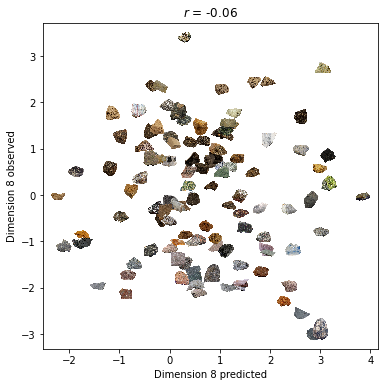

In [31]:
plot_predictions(8, mds_obs, cnn_ownpred, rock_images)